# Calculate the AVR as a function of effective temperature.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Gaia-McQuillan crossmatch and make cuts.

In [3]:
gaia_mc0 = pd.read_csv("gaia_mc2.csv")
print(np.shape(gaia_mc0))

# Cut out visual binaries.
gaia_mc1 = gaia_mc0.iloc[gaia_mc0.flag.values == 1]
print(np.shape(gaia_mc1), "no visual binaries or subgiants")

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc1.age.values > .5
print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars. The hot limit is usually 5000 and the cool usually 3500
mint, maxt = 3500, 5500
m &= (gaia_mc1.color_teffs.values < maxt) * (mint < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

# Try cutting out stars with latitudes greater than bmax degrees
# bmax = 20
bmax = 15
m &= gaia_mc1.b.values < bmax
print(np.shape(gaia_mc1.iloc[m]), "no high latitude stars")

# # Restrict to stars with Vz
# m &= np.isfinite(gaia_mc1.vz.values)
# print(np.shape(gaia_mc1.iloc[m]), "only stars with Vz")

gaia_mc = gaia_mc1.iloc[m]

(31357, 133)
(11700, 133) no visual binaries or subgiants
(11436, 133) no large vb uncertainties
(11272, 133) no faint stars
(10586, 133) no rapid rotators
(10454, 133) no hot or cold stars
(6879, 133) no high latitude stars


Make cuts in log age.

In [4]:
age_bins = 10**np.linspace(np.log10(.5), np.log10(3.5), 7)
mid_age_bins = age_bins[:-1] + .5*np.diff(age_bins)
age_masks = select_stars(gaia_mc, age_bins, "age")

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Format data.

In [5]:
x = gaia_mc.color_teffs.values
y = gaia_mc.Prot.values
v = gaia_mc.vb.values
verr = gaia_mc.vb_err.values
xerr = np.ones_like(x)*100

tbins = np.linspace(min(x), max(x), 10)
mid_tbins = .5*np.diff(tbins) + tbins[:-1]
ds, derrs = [np.zeros((len(age_bins), len(tbins[:-1]))) for i in range(2)]

Calculate dispersion as a function of age and temperature.

In [6]:
for i, m in enumerate(age_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    d, derr, k, kerr = MC_dispersion(x[m][clipping_mask], v_clipped, xerr[m][clipping_mask], 
                                     verr[m][clipping_mask],
                                     tbins, 1000, method="std")
    ds[i, :] = d
    derrs[i, :] = err_on_sample_std_dev(d, len(x[m][clipping_mask]))
#     derrs[i, :] = derr

  6%|▋         | 64/1000 [00:00<00:01, 636.72it/s]

niter =  3 5 stars removed kurtosis =  0.1696824430507773


  6%|▋         | 65/1000 [00:00<00:01, 643.89it/s]

niter =  2 2 stars removed kurtosis =  -0.06656621409754226


  7%|▋         | 69/1000 [00:00<00:01, 678.53it/s]

niter =  3 4 stars removed kurtosis =  -0.36882778417153217


  6%|▋         | 64/1000 [00:00<00:01, 636.73it/s]

niter =  3 7 stars removed kurtosis =  -0.1370116253934519


 13%|█▎        | 130/1000 [00:00<00:01, 647.61it/s]

niter =  3 15 stars removed kurtosis =  0.14733090090795953


  6%|▌         | 57/1000 [00:00<00:01, 568.91it/s]

niter =  3 12 stars removed kurtosis =  0.1369199502201175


100%|██████████| 1000/1000 [00:01<00:00, 617.17it/s]


Calculate the AVR for each temperature bin (ds = [age_bins, tbins-1]). Exclude the oldest and youngest bins from the fit.

Text(0, 0.5, '$\\mathrm{\\sigma_{vb}}$')

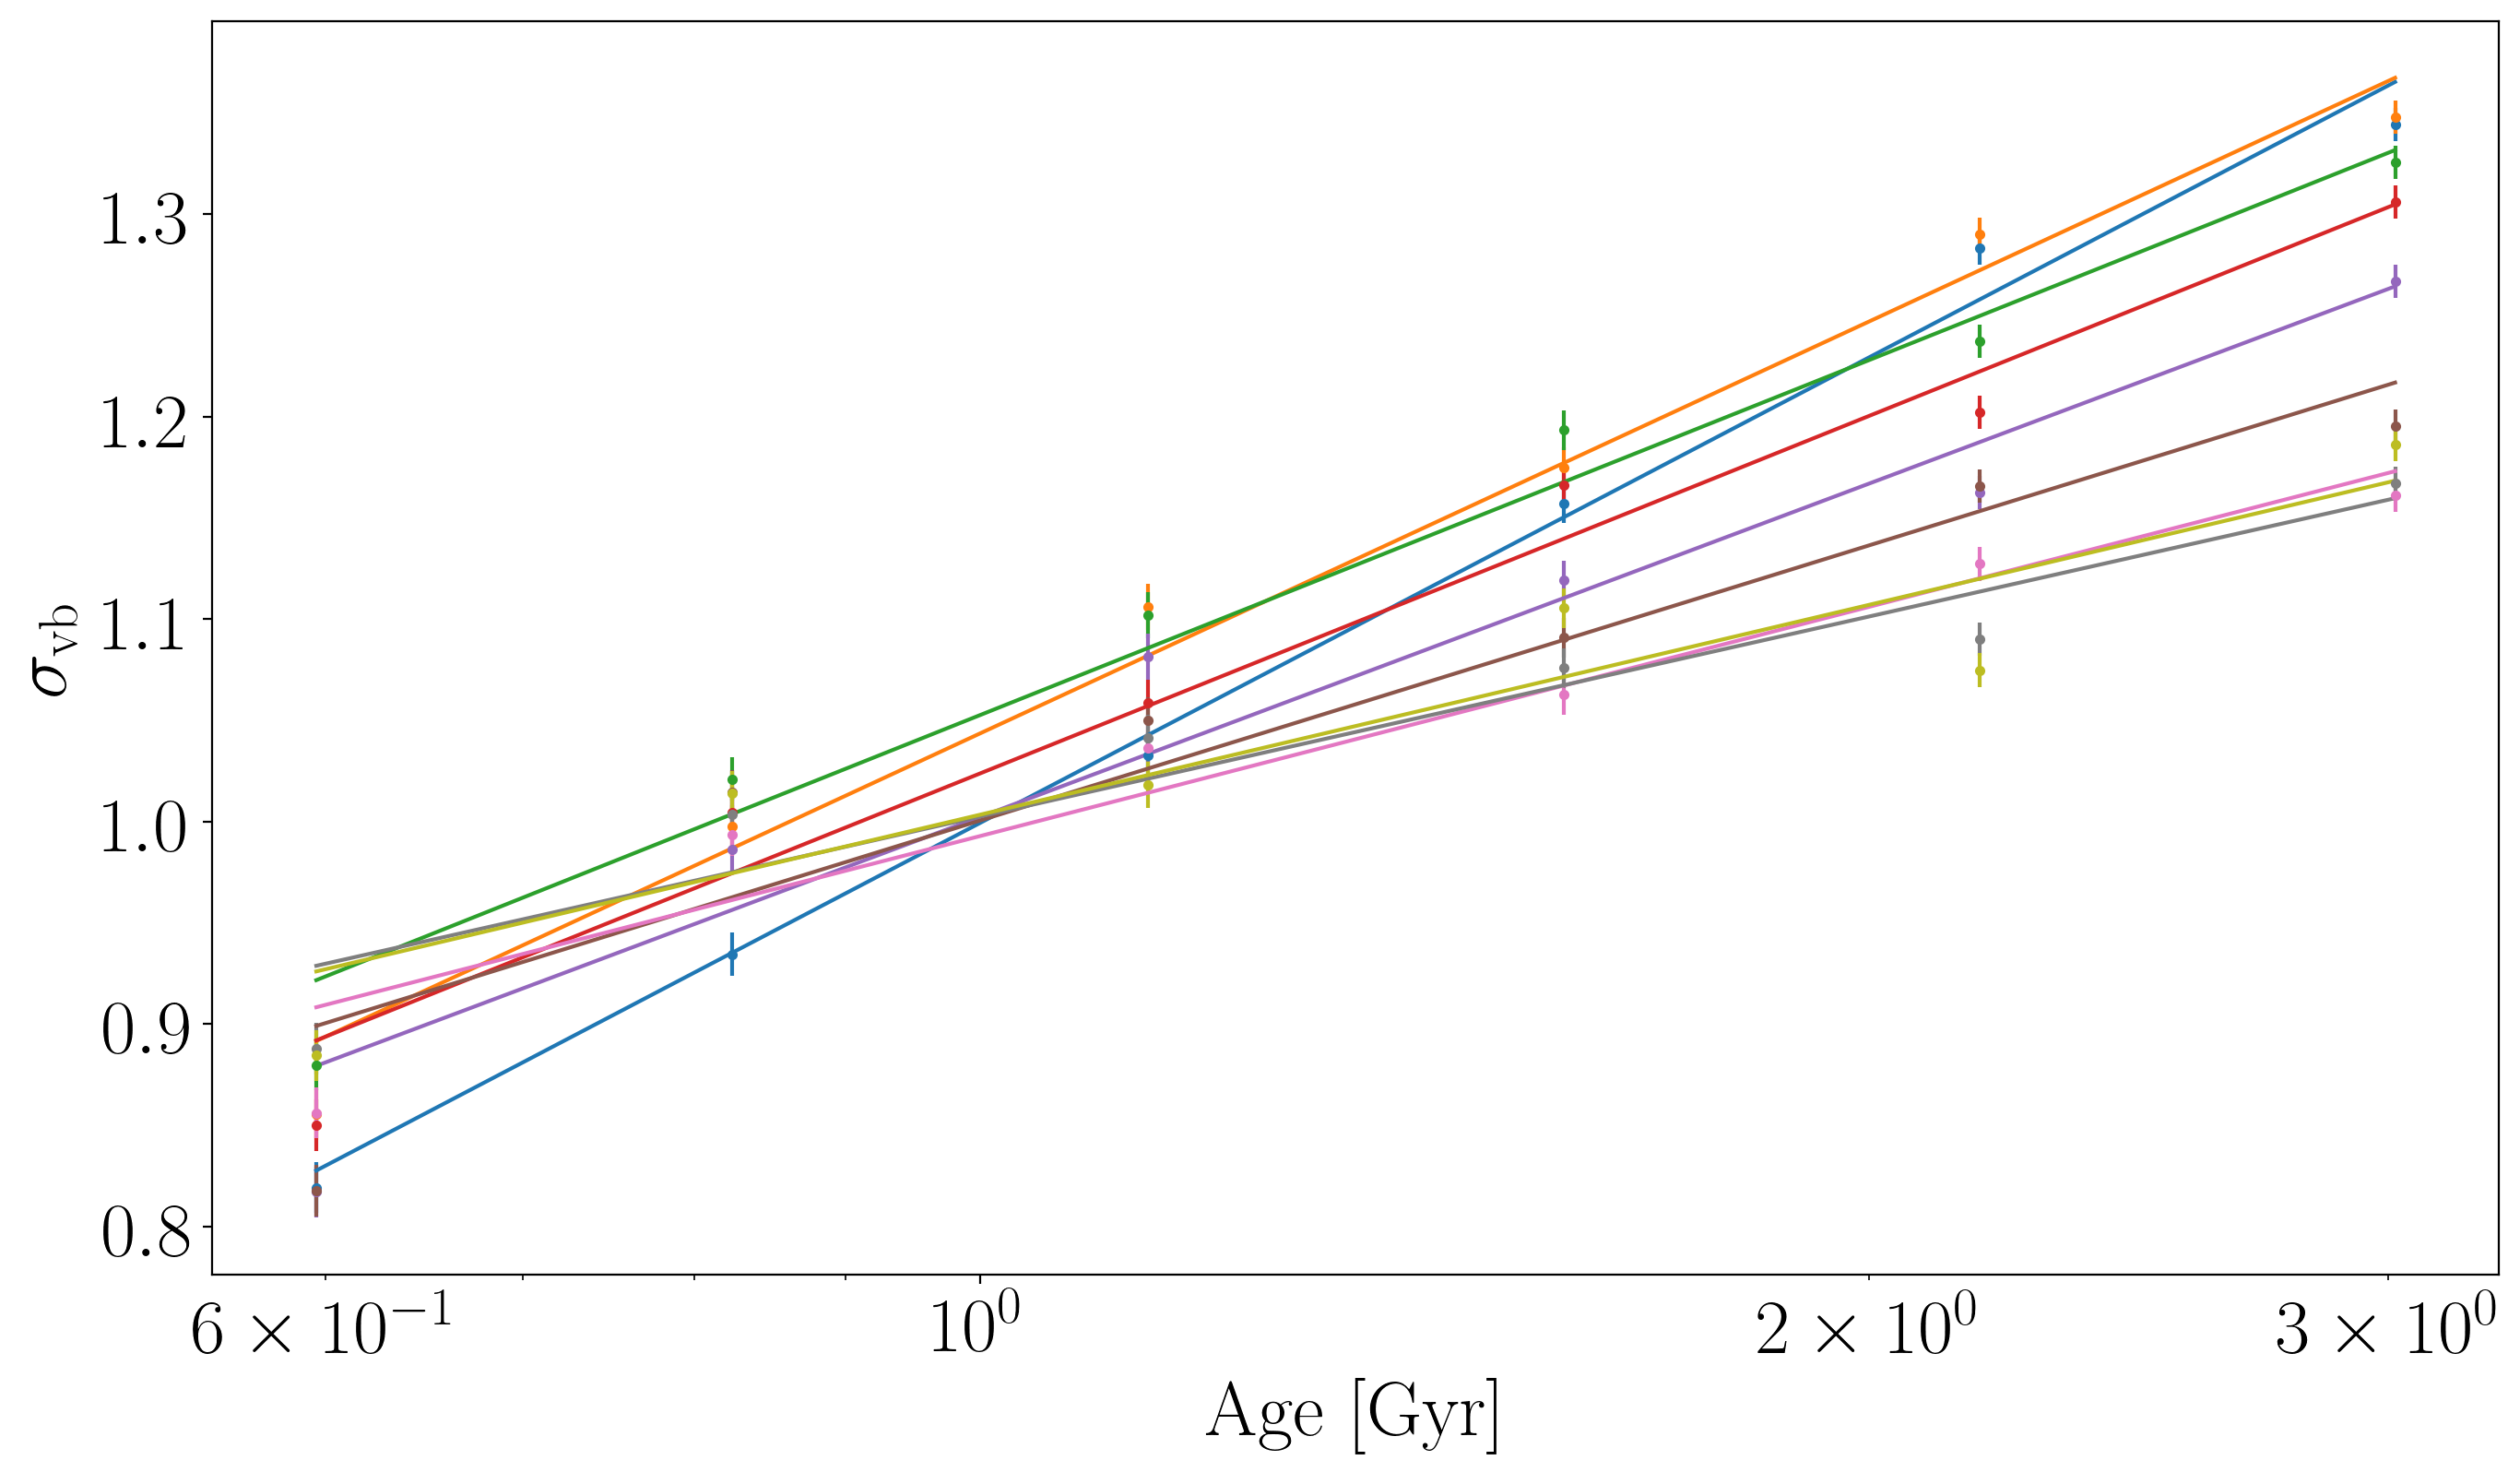

In [7]:
plt.figure(figsize=(16, 9), dpi=200)

x = (np.log10(mid_age_bins))
z = mid_tbins

w1s, w1errs = [np.zeros(len(z)) for i in range(2)]
for i in range(len(z)):
    
    y = np.log10(ds[:, i][:-1])
    yerr = err_to_log10_err(ds[:, i][:-1], derrs[:, i][:-1])
    
    w, wcovar = fit_line(x, y, yerr)
    w1s[i] = w[1]
    w1errs[i] = np.sqrt(wcovar[1, 1])
    
    plt.errorbar(10**x, y, yerr=yerr, fmt=".", color="C{}".format(i))
    plt.plot(10**x, w[0] + w[1]*x, color="C{}".format(i))

plt.xscale("log")
plt.xlabel("$\mathrm{Age~[Gyr]}$")
plt.ylabel("$\mathrm{\sigma_{vb}}$")

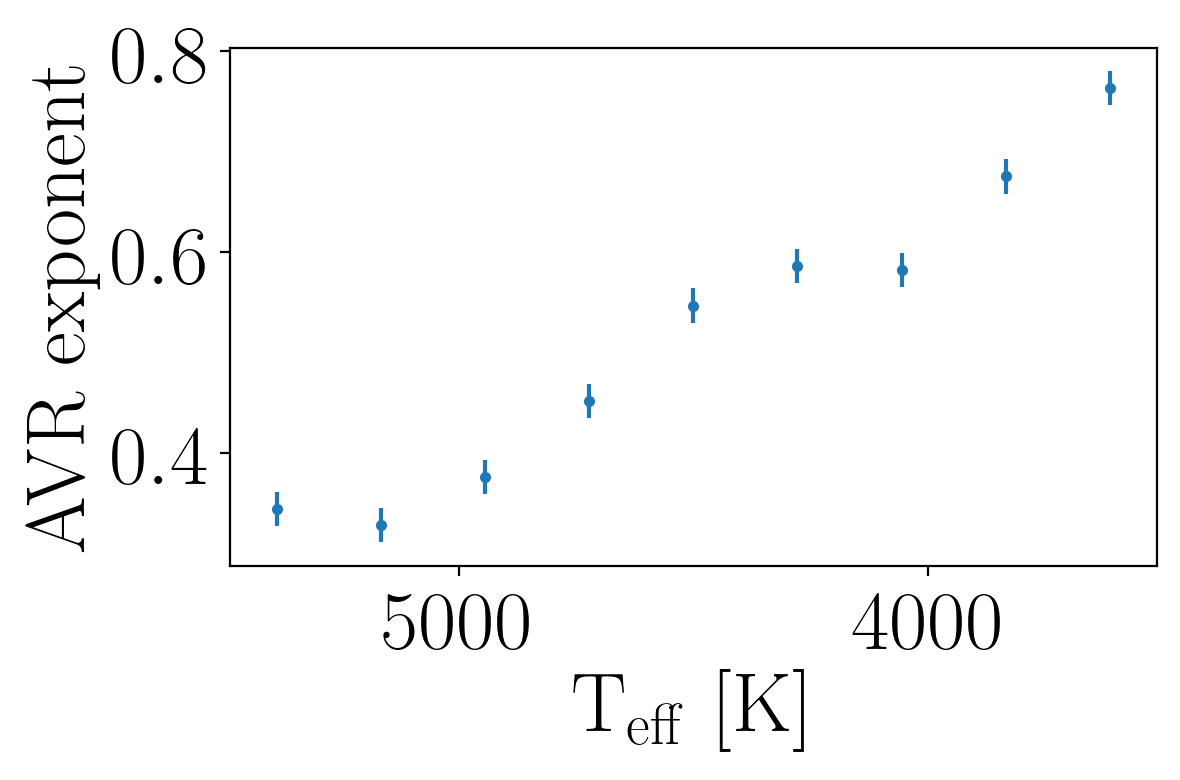

In [8]:
plt.figure(dpi=200)
plt.errorbar(mid_tbins, w1s, yerr=w1errs, fmt=".")
plt.xlim(max(mid_tbins)+100, min(mid_tbins)-100)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{AVR~exponent}$")
plt.tight_layout()
plt.savefig("paper/AVR_exponent.pdf")

In [9]:
print("minimum beta = {0:.2f} +\- {1:.2f}".format(w1s[-1], w1errs[-1]))
print("maximum beta = {0:.2f} +\- {1:.2f}".format(w1s[0], w1errs[0]))

minimum beta = 0.34 +\- 0.02
maximum beta = 0.76 +\- 0.02


In [10]:
print(tbins)

[3501.36676514 3723.35526569 3945.34376625 4167.3322668  4389.32076736
 4611.30926791 4833.29776847 5055.28626902 5277.27476957 5499.26327013]
